In [1]:
import torch
import numpy as np
import glob
import os
from fastai.data.core import DataLoaders
import random
import torch.nn.functional as F
from fastai.vision.all import *

In [2]:
class DataLoaderSegmentation(torch.utils.data.Dataset):
    def __init__(self, folder_path, interp_size = 480):
        super(DataLoaderSegmentation, self).__init__()
        self.interp_size = interp_size
        self.img_files = glob.glob(os.path.join(folder_path,'features','*.npy'))
        self.mask_files = []
        for img_path in self.img_files:
             self.mask_files.append(os.path.join(folder_path,'masks',os.path.basename(img_path)) )

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            
            data = np.load(img_path)
            label = np.load(mask_path)
            
            data = torch.from_numpy(data).float()
            label = torch.from_numpy(label).float()
            
            return F.interpolate(data.unsqueeze(0), (self.interp_size, self.interp_size)).squeeze(0), F.interpolate(label.unsqueeze(0), (self.interp_size, self.interp_size)).squeeze(0)

    def __len__(self):
        return len(self.img_files)

In [3]:
ds_train = DataLoaderSegmentation(os.path.join('data', 'yeast_processed_norm', 'train'))
ds_test = DataLoaderSegmentation(os.path.join('data', 'yeast_processed_norm', 'test'))

In [4]:
ds_train.__len__(), ds_test.__len__()

(1445, 161)

In [10]:
sample = ds_train.__getitem__(12)

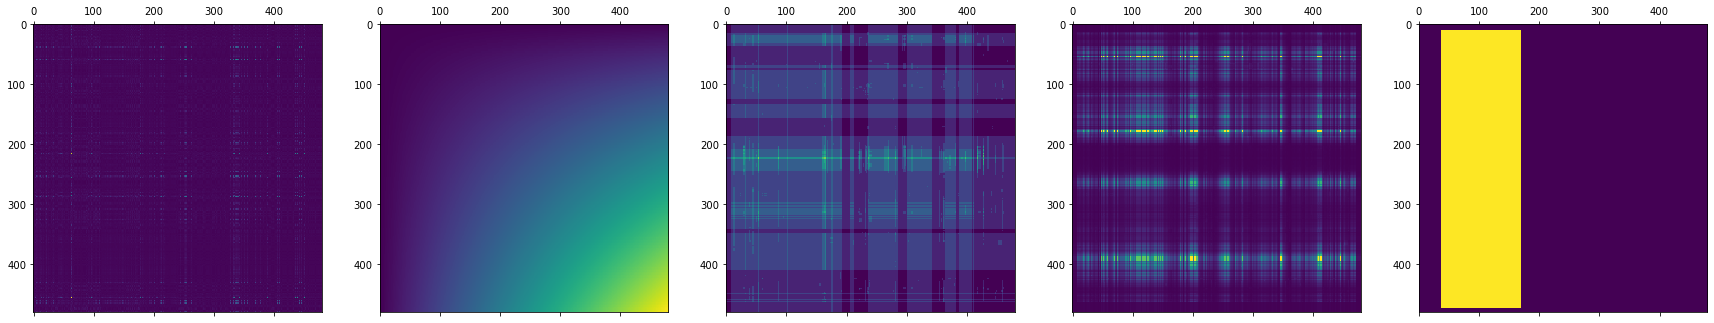

In [11]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,5, figsize=(30,30))
axs[0].matshow(sample[0][0])
axs[1].matshow(sample[0][1])
axs[2].matshow(sample[0][2])
axs[3].matshow(sample[0][3])
axs[4].matshow(sample[1][0])
plt.show()

In [6]:
ds_train.__getitem__(0)[0].shape, ds_train.__getitem__(0)[1].shape

(torch.Size([4, 480, 480]), torch.Size([1, 480, 480]))

In [7]:
torch.unique(ds_train.__getitem__(0)[1])

tensor([0., 1.])

In [34]:
dls = DataLoaders.from_dsets(ds_train, ds_test, bs=4, num_workers=0)

In [35]:
dls.one_batch()[0].shape

AttributeError: 'DataLoader' object has no attribute 'one_batch'

In [29]:
dls.cuda()

AttributeError: 'DataLoaderSegmentation' object has no attribute 'cuda'

In [30]:
def acc(input, target):
    target = target.squeeze(1)
    return (target==input).float().mean()

In [32]:
learn = unet_learner(dls, models.resnet34, loss_func=BCELossFlat(axis=1), n_in=4, n_out=1, wd=1e-2, y_range=(0,1))

AttributeError: 'DataLoaderSegmentation' object has no attribute 'train'

In [13]:
torch.cuda.set_device(0)
torch.cuda.get_device_name(0)
torch.set_num_threads(1)
learn.model
learn.model.cuda()

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [14]:
torch.cuda.get_device_name(0)

'GeForce RTX 2070'

SuggestedLRs(lr_min=3.981071640737355e-05, lr_steep=3.0199516913853586e-05)

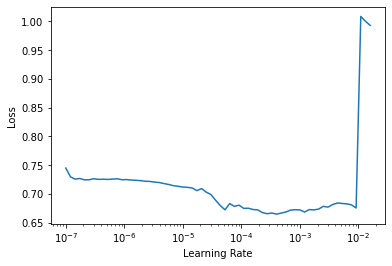

In [15]:
learn.freeze()
learn.lr_find()
# learn.recorder.plot()

In [16]:
learn.fit_one_cycle(1, slice(2e-5), pct_start=0.9)

epoch,train_loss,valid_loss,acc,time
0,0.567567,0.552839,0.000000,03:15


SuggestedLRs(lr_min=4.78630090583465e-07, lr_steep=0.0004786300996784121)

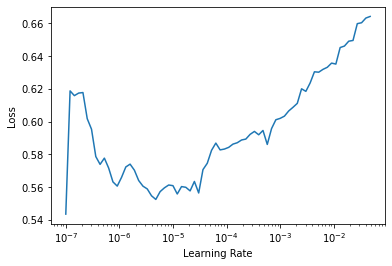

In [17]:
learn.unfreeze()
learn.lr_find()

In [18]:
learn.fit_one_cycle(25, slice(5e-7), pct_start=0.9)

epoch,train_loss,valid_loss,acc,time
0,0.550664,0.551539,0.000000,03:15
1,0.563183,0.550251,0.000000,03:15
2,0.553043,0.550742,0.000000,03:14
3,0.559536,0.550329,0.000000,03:13
4,0.557251,0.549942,0.000000,03:12
5,0.563991,0.547097,0.000000,03:13
6,0.556727,0.545936,0.000000,03:15
7,0.557959,0.546483,0.000000,03:14
8,0.552803,0.544901,0.000000,03:14
9,0.548323,0.543114,0.000000,03:14


In [20]:
learn.save('unet-stage1')

Path('models/unet-stage1.pth')

In [21]:
learn.model.eval()

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [24]:
layers = [learn.model, nn.Hardsigmoid()]
predictor = nn.Sequential(*layers)